In [1]:
import requests
import os
import json
import asyncio
from dotenv import load_dotenv
load_dotenv()

import sys
PARENT_DIR = os.path.dirname(os.getcwd())
src_path = os.path.join(PARENT_DIR, '')
print(src_path)
sys.path.append(src_path)


/Users/shotomorisaki/Engineering/X-Developper-Challenge-Search/backend/


In [2]:
from Twitter.recent_search import recent_search
from Twitter.process_queries import analyze
from Twitter.rank_tweets import rank_tweets, similarity_scorer

DATA_DIR = os.path.join(os.getcwd(), "data")

/Users/shotomorisaki/Engineering/X-Developper-Challenge-Search/.venv/lib/python3.9/site-packages/pinecone/data/index.py:1: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
# def get_results(query):
#     res = analyze(query)
#     description = res["description"]
#     subqueries = res["subqueries"]
#     data = {"queries": []}
#     for item in subqueries:
#         query =  item
#         search_result = recent_search(query, 25)
#         formatted_result = json.dumps(json.loads(search_result), indent=4)
#         scoring = similarity_scorer(query, description)
#         print(scoring)
#         if(scoring > 0.85):
#             print("Pass")
#             data["queries"].append({"query": query, "results": formatted_result})
#         else:
#             pass
#     sorted_tweets = rank_tweets(data["queries"], description)
#     # print(sorted_tweets)
    
#     return json.dumps([res, sorted_tweets], default=float)

async def get_results(query):
    res = analyze(query)
    description = res["description"]
    subqueries = res["subqueries"]
    data = {"queries": []}

    async def fetch_and_format(query):
        search_result = recent_search(query, 10)
        formatted_result = json.dumps(json.loads(search_result), indent=4)
        return {"query": query, "results": formatted_result}

    fetch_tasks = [fetch_and_format(item) for item in subqueries]
    results = await asyncio.gather(*fetch_tasks)
    data["queries"].extend(results)

    with open("recent_search_queries.json", 'w') as file:
        json.dump(data["queries"], file, indent=4, sort_keys=True)
    sorted_tweets = await rank_tweets(data["queries"], description)
    return json.dumps([res, sorted_tweets], default=float)

In [25]:
result_container = get_results("NBA playoff")

In [26]:
result_container_load = await result_container  # Assuming result_container is a coroutine
result_container_str = json.dumps(result_container_load)
result_container_load = json.loads(result_container_str)
sorted_tweets = result_container_load[1]

In [39]:
result_container = get_results("NBA playoff")
result_container_load = await result_container  # Assuming result_container is a coroutine

# Parsing the string as JSON
result_container_load = json.loads(result_container_load)

# Extracting the description from the first element of the list
tweets_data = result_container_load[1]

/var/folders/_n/zkwnlxm959j1s3pt15cz_xmw0000gn/T/ipykernel_17586/3407411156.py:12: UserWarning: Glyph 128308 (\N{LARGE RED CIRCLE}) missing from current font.
  plt.tight_layout()
/var/folders/_n/zkwnlxm959j1s3pt15cz_xmw0000gn/T/ipykernel_17586/3407411156.py:12: UserWarning: Glyph 128064 (\N{EYES}) missing from current font.
  plt.tight_layout()
/var/folders/_n/zkwnlxm959j1s3pt15cz_xmw0000gn/T/ipykernel_17586/3407411156.py:12: UserWarning: Glyph 128081 (\N{CROWN}) missing from current font.
  plt.tight_layout()
/var/folders/_n/zkwnlxm959j1s3pt15cz_xmw0000gn/T/ipykernel_17586/3407411156.py:12: UserWarning: Glyph 127936 (\N{BASKETBALL AND HOOP}) missing from current font.
  plt.tight_layout()
/var/folders/_n/zkwnlxm959j1s3pt15cz_xmw0000gn/T/ipykernel_17586/3407411156.py:12: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  plt.tight_layout()
/var/folders/_n/zkwnlxm959j1s3pt15cz_xmw0000gn/T/ipykernel_17586/3407411156.py:12: UserWarning: Glyph 127942 (\N{TROPHY}) mi

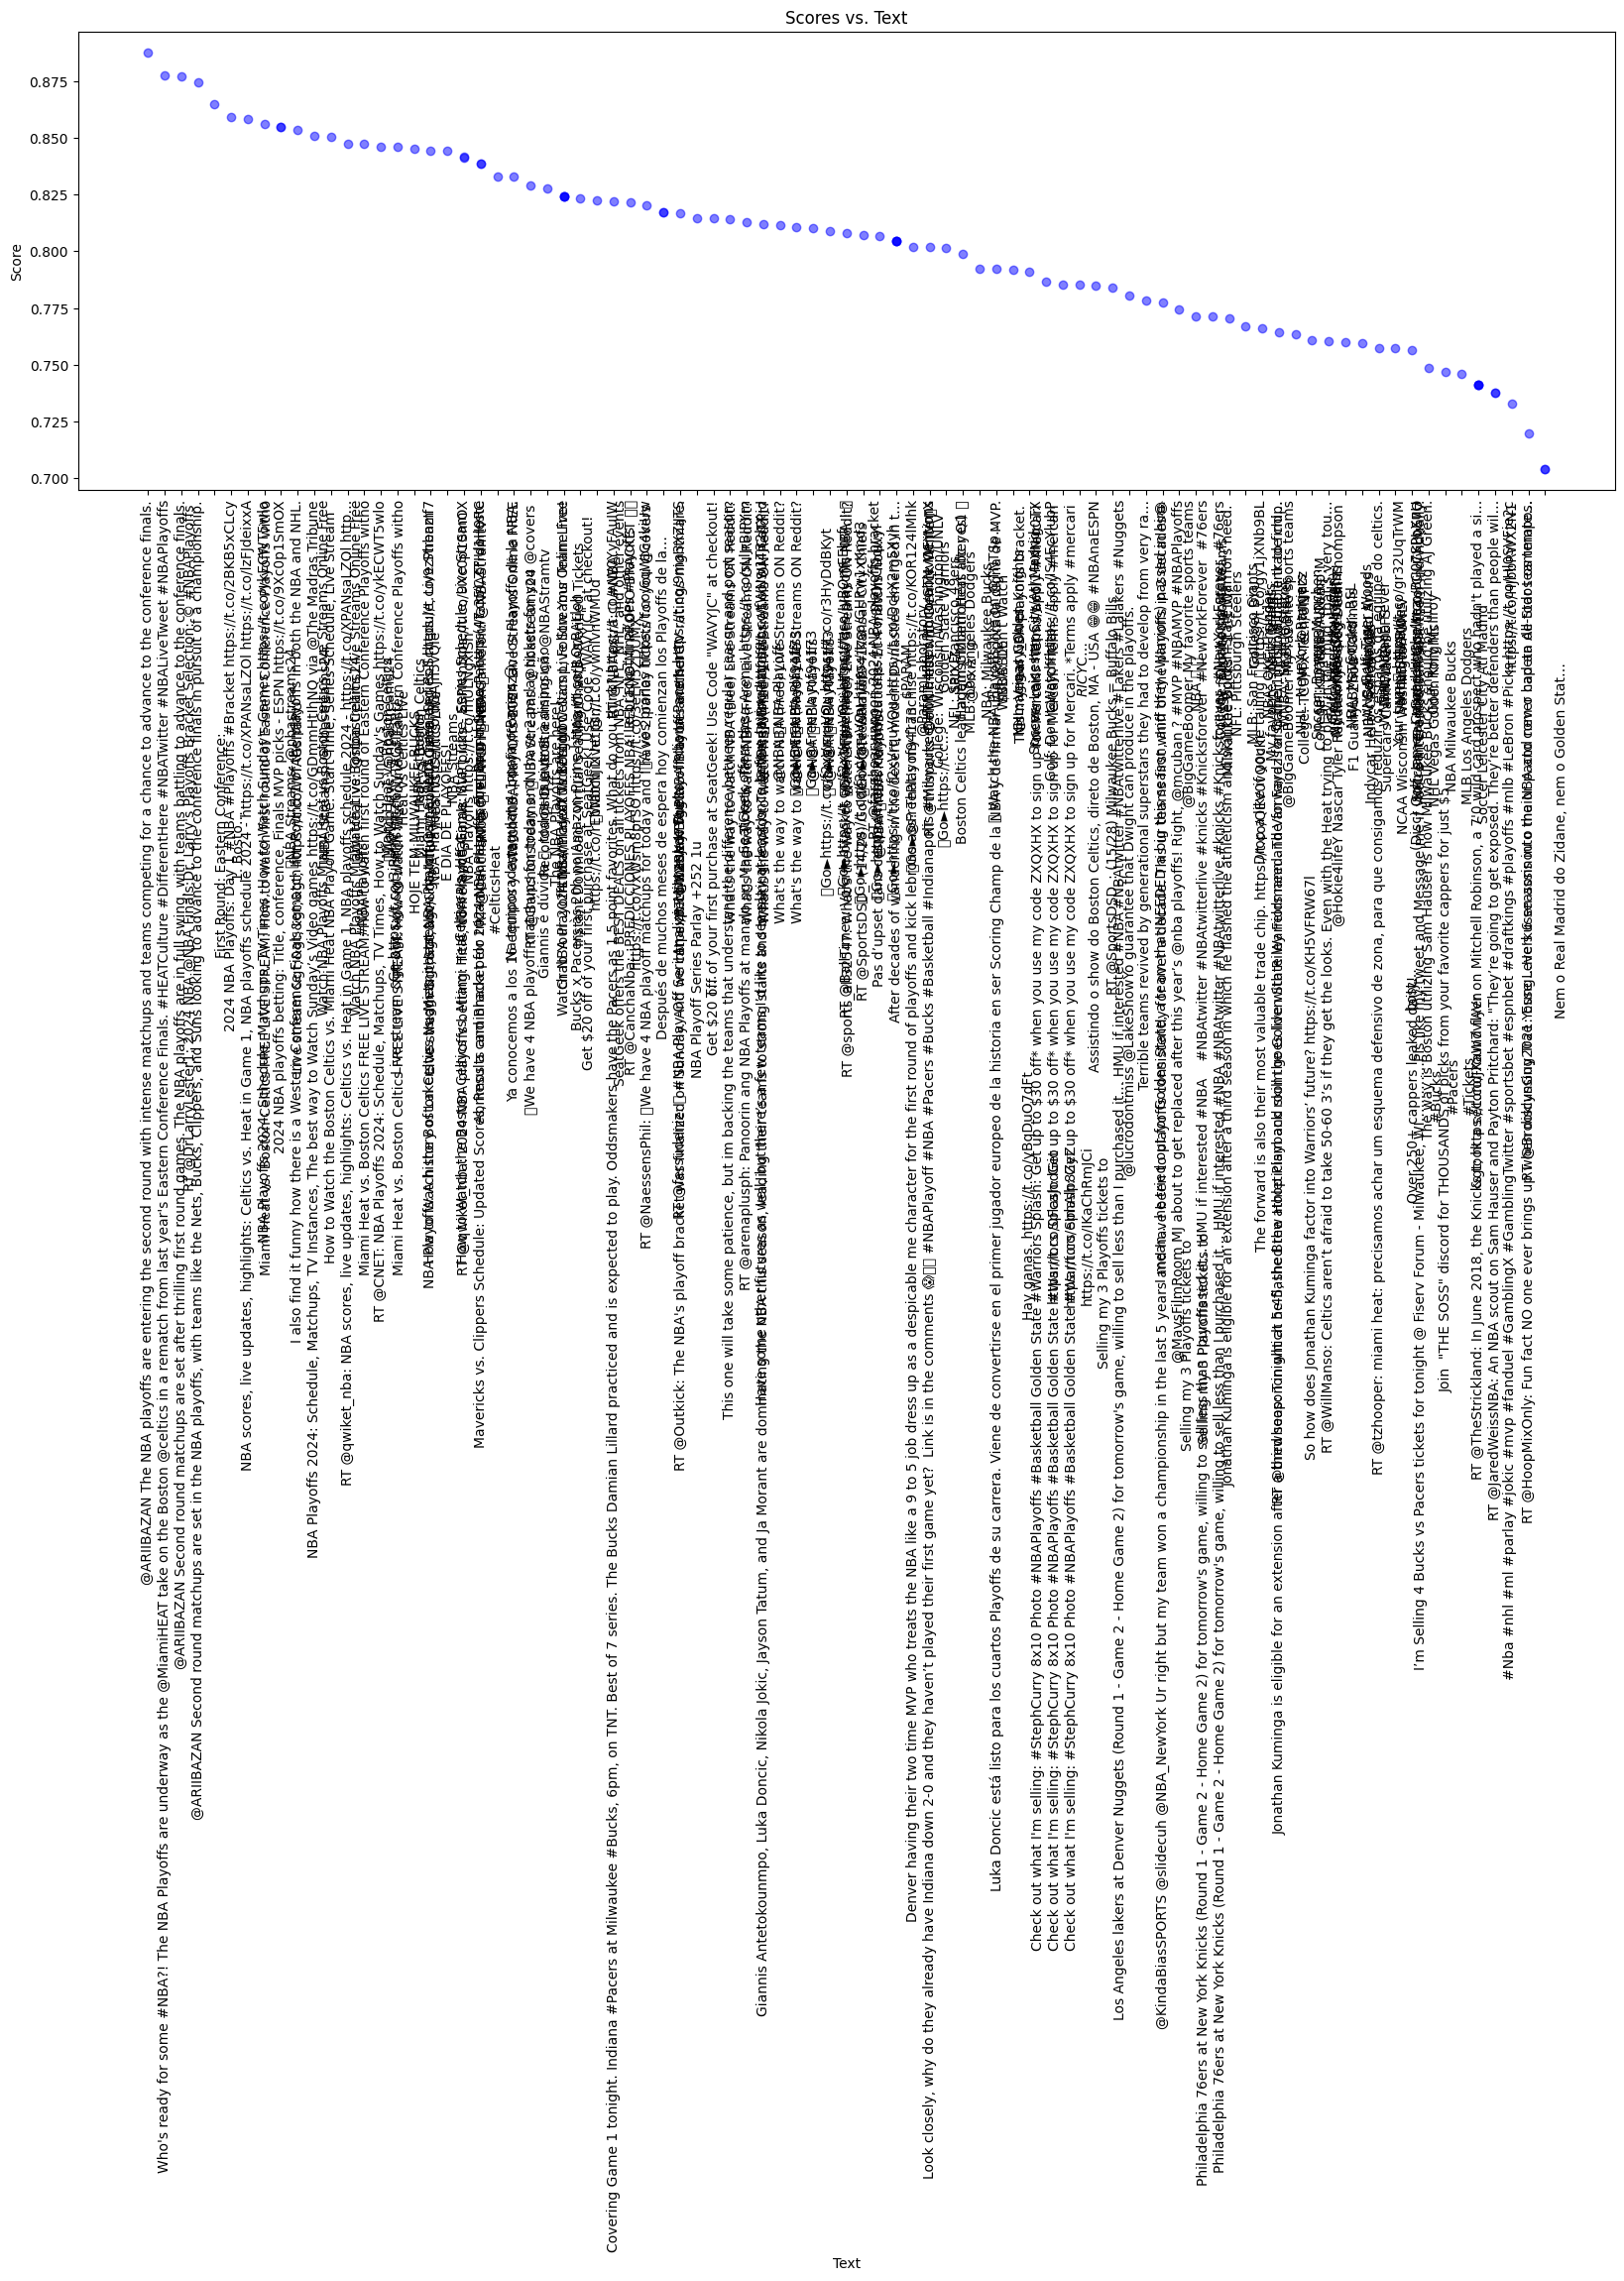

In [42]:
scores = [tweet["score"] for tweet in tweets_data]
texts = [tweet["tweet"]["text"] for tweet in tweets_data]

# Plotting
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 6))
plt.scatter(texts, scores, color='blue', alpha=0.5)
plt.xlabel('Text')
plt.ylabel('Score')
plt.title('Scores vs. Text')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()